# Classification of embryonic stem cell-derived cardiomyocites based on their action potentials
In this project we look at the problem of immature cardiac cell classification using the cell's _Action Potential_ (AP). In particular, we are interested in predicting whether an immature cardiomyocite will differentiate into a specific phenotype (e.g. atrial or ventricular). Having a method to correctly determining the phenotype at an early stage of the cell differentiation is of particular interest in the development of regenerative medical therapies of myocardium repair (e.g. after an infarct).

In [5]:
# ============================================================================
# import modules
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd

# inline plots
%matplotlib inline

# ============================================================================
# data loading
# ============================================================================


# load Adult dataset
def get_AdultDataset():
    """
    This function returns the data points, labels, and temporal discretization of
    the recorded action potentials for the synthetic adult dataset. Labels are
    {-1: atrial type, 1: ventricular type}.
    """
    
    # load matlab file 
    adata = scipy.io.loadmat('./data/Adult_samples.mat')
    
    # sampling frequency
    fs = 500.0

    # assign data to variables
    X = np.concatenate((adata['Vatrial'],adata['Vventricular']),axis=1)
    # labels
    y = np.ones((1,X.shape[1]))
    y[0,:1000]=-1
    # time discretization
    t = np.reshape(np.arange(0,X.shape[0])/fs,(-1,1))
    return X,y,t

# load Kamp dataset
def get_KampDataset():
    """
    This function returns the data points, labels, and temporal discretization of
    the recorded action potentials for the Kamp dataset. Labels are {-1: atrial type,
    1: ventricular type}.
    """
    
    # load matlab file (MODIFY DATA PATH IF NEEDED)
    mdict = scipy.io.loadmat('./data/Kamp_data.mat')
    
    # print dictionary keys
    print(mdict.keys())
    
    # assign data to variables
    t = mdict['time']
    X = mdict['voltage']         # each column is a data point
    y = mdict['label'].astype(np.float16)
    
    # map labels to {-1,1}, original labels are {1:atrial,2:ventricular}
    y[y==1] = -1 # atrial-type
    y[y==2] = 1  # ventricular-type
    
    return X,y,t


# load test data, unlabeled embryonic cardiomyocite APs
def get_OpticalDataset(cell_aggregate=1):
    """
    This function returns the data points (in matrix form, samples are columns) and
    the temporal sampling instants of a given cell aggregate {1,...,9} (default=1).
    """
    
    # matlab file 
    matfile = './data/optical_data/Optical_data_%.2d.mat'%(cell_aggregate)

    # load data
    odict = scipy.io.loadmat(matfile)
    
    # assign data to variables
    X = odict['voltage']
    t = odict['time']
    
    return X,t


# ============================================================================
# data plotting, segmentation plot
# ============================================================================

def get_aggregate_img(cell_aggregate=1,label=None):
    """
    This function returns an image of a given cell aggregate from the Optical
    Dataset. Use:
    
            img = get_aggregate_img(cell_aggregate=1,label)
    
    Inputs:
        cell_aggregate : {[1],...,9} cell aggregate identifier
        label : [None] array of labels corresponding to the cell aggregate
        
    Outputs:
        img : An image (2D array) of the cell aggregate
    """
    
    # load binary image mask
    matfile = './data/optical_data/Labels2Image_%.2d.mat'%(cell_aggregate)
    mlabel = scipy.io.loadmat(matfile)
    
    # get rows, columns of non-zero pixels
    c,r = np.where(mlabel['goodpixels'].T)

    # create label image
    img = np.zeros_like(mlabel['goodpixels'])

    # add class label (e.g. {1,3})
    if not label is None:
        if len(label) != len(c):
            print('Error: dimension mismatch between label vector and cell aggregate')
            return None
        for ii in range(len(r)):
            img[r[ii],c[ii]] = label[ii]+2
    else:
        for ii in range(len(r)):
            img[r[ii],c[ii]] = 1

    return img


### Data loading example
In the following cell you will find an example on how to load the data.

['__globals__', '__header__', 'label', 'voltage', 'time', '__version__']


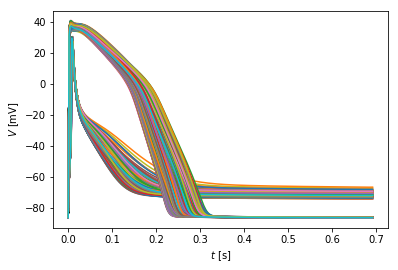

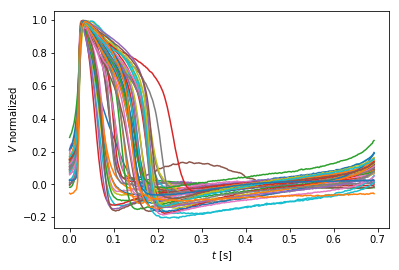

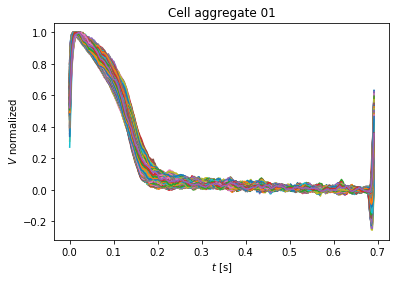

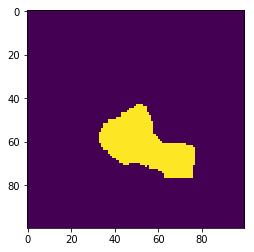

In [6]:
# loading the Adult dataset
X,y,t = get_AdultDataset()

# signal display
plt.figure()
plt.plot(t,X)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$V$ [mV]')


# ----------------------------------------------------------------------------

# loading the Kamp dataset
X,y,t = get_KampDataset()

# signal display
plt.figure()
plt.plot(t,X)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$V$ normalized')

# ----------------------------------------------------------------------------

# loading the test set (there are nine files {1,...,9})
Xtest,t = get_OpticalDataset(cell_aggregate=1)

# signal display
plt.figure()
plt.plot(t,Xtest)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$V$ normalized')
plt.title('Cell aggregate %.2d'%(1))

# get segmentation image, if no labels provided it returns a binary image
img = get_aggregate_img(cell_aggregate=1,label=None)
# display image
plt.figure()
plt.imshow(img)



In [9]:
# Unsupervised and Supervised Learning Algorithms

import pandas as pd

def kmeans(X,k,niter):
    """
    This function implements the K-means clustering algorithm.

    Use: groups = kmeans(X,k,niter)
    
    Inputs:
        X : Data points, each column is a point (nfeatures x nsamples).
        k : Number of clusters.
        N : Number of random initializations of the K-means algorithm.
        
    Outputs:
        groups : Vector with group labels {1,...,k}^{nsamples}
    """
    nfeatures = len(X[:,0])
    nsamples = len(X[0])
    ideal_cluster_centers = np.zeros((nfeatures, k))
    
    for iter_number in range(niter):    
        
        minimum_solution_distance = 0
        cur_total_dist = -2
        prev_total_dist = -1
        cluster_centers = np.random.rand(nfeatures, k)
        
        #Iterates until it minimizes
        while(cur_total_dist < prev_total_dist):
            prev_total_dist = cur_total_dist
            cur_total_dist = 0
            cluster_assignments = k*[0]
            clustering_labels = np.zeros(nsamples)
            for i in range(nsamples):
                min_dist = 0
                for j in range(k):
                    dist = np.linalg.norm(X[:,i] - cluster_centers[:,j])
                    if j == 0 or dist < min_dist:
                        min_dist = dist
                        cur_min_index = j
                cur_total_dist += min_dist
                clustering_labels[i] = cur_min_index
                if np.shape(cluster_assignments[cur_min_index]) == ():
                    cluster_assignments[cur_min_index] = X[:,[i]]
                else:
                    cluster_assignments[cur_min_index] = np.append(cluster_assignments[cur_min_index], X[:,[i]], axis = 1)
            for i in range(k):
                if np.shape(cluster_assignments[i]) != ():
                    cluster_centers[:,[i]] = np.mean(cluster_assignments[i], axis = 1, keepdims = True)
            if prev_total_dist < 0:
                prev_total_dist = cur_total_dist + 1
        #after you're done, you will have cluster_assignments w a min, cur_total_distance as a min, and cluster_centers
        
        if iter_number == 0 or cur_total_dist < minimum_solution_distance:
            minimum_solution_distance = cur_total_dist
            ideal_clustering_labels = clustering_labels[i]
    return clustering_labels

    
def dbscore(X,Y):
    """
    This function computes the Davies-Bouldin index between two classes.
    
    Use:  dbi = dbscore(X,Y)
    
    Inputs:
        X : Points in group one (nfeatures,nsamples1)
        Y : Points in second group (nfeatures,nsamples2)
        
    Outputs:
        dbi : Davies-Bouldin index (score)
    """
    nfeatures = len(X[:,0])
    nsamples1 = len(X[0])
    nsamples2 = len(Y[0])
    
    center_x = np.mean(X, axis = 1, keepdims = True)
    center_y = np.mean(Y, axis = 1, keepdims = True)
    center_difference = np.linalg.norm(center_x - center_y)
    
    x_spread = 0
    y_spread = 0
    for i in range(nsamples1):
        x_spread += np.linalg.norm(X[:,[i]] - center_x)
    x_spread = x_spread / nsamples1
    for i in range(nsamples2):
        y_spread += np.linalg.norm(Y[:,[i]] - center_y)
    y_spread = y_spread / nsamples2
    #Since there are only 2 groups, the DBI is given by
    dbi = (x_spread + y_spread)/center_difference
    return dbi

def nn_classifier(sample, features, labels):
    #Loops through the test features and finds the closest point to the sample.
    for i in range(len(features[0])):
        distance = np.linalg.norm(sample - features[:,[i]])**2
        if i == 0:
            min_index = 0
            min_distance = distance
        elif distance < min_distance:
            min_distance = distance
            min_index = i
    return labels[min_index] 

def apd_calc(data, percent):
    apd_index = 0
    max_index = np.argmax(data)
    for i in range(max_index, len(data)):
        if data[i] <= (percent):
            apd_index = i
            break;
    return (apd_index - max_index)/500.0

def cum_error_calc(classification, expected):
    error_count = 0.0
    for i in range(len(expected)):
        if classification[i] != expected[i]:
            error_count += 1.0
    return 1-(error_count/len(expected))

In [10]:
#Extracting the data sets
syn_adult_data, syn_adult_labels, syn_adult_t = get_AdultDataset()
for i in range(len(syn_adult_data[0])):
    resting_potential = syn_adult_data[len(syn_adult_data) - 1][i]
    syn_adult_data[:,i] -= resting_potential
    syn_adult_data[:,i] = syn_adult_data[:,i] / np.amax(syn_adult_data[:,i])
syn_adult_labels = syn_adult_labels[0]

kamp_data, kamp_labels, kamp_t = get_KampDataset()
kamp_labels = kamp_labels[0]
optical_data = []
for i in range(9):
    optical_data.append(get_OpticalDataset(cell_aggregate = i+1))

all_data = syn_adult_data
all_data = np.append(all_data, kamp_data, axis = 1)
for i in range(9):
    all_data = np.append(all_data, optical_data[i][0], axis = 1)

#Set-up PCA Features
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
mean = np.mean(all_data, axis = 1, keepdims = True)
all_data_pca = pca.fit_transform((all_data - mean).T).T

#####Synthetic Adult Feature Extraction#####
#PCA
syn_adult_data_pca = all_data_pca[:, 0:len(syn_adult_labels)]

#APD
syn_adult_data_handcrafted = np.zeros((2, len(syn_adult_data[0])))
for i in range(len(syn_adult_data_handcrafted[0])):
    syn_adult_data_handcrafted[0][i] = apd_calc(syn_adult_data[:,i], 0.5)
    syn_adult_data_handcrafted[1][i] = syn_adult_data[:,i].mean()

#####Kamp Data Feature Extraction#####
#PCA
kamp_data_pca = all_data_pca[:, len(syn_adult_labels): len(syn_adult_labels) + len(kamp_labels)]

#APD
kamp_data_handcrafted = np.zeros((2, len(kamp_data[0])))
for i in range(len(kamp_data_handcrafted[0])):
    kamp_data_handcrafted[0][i] = apd_calc(kamp_data[:,i], 0.5)
    kamp_data_handcrafted[1][i] = kamp_data[:,i].mean()


####Optical Data Set
optical_data_pca = []
index = len(syn_adult_labels) + len(kamp_labels)
for i in range(9):
    length = len(optical_data[i][0][0])
    optical_data_pca.append(all_data_pca[:, index: index + length])
    index = index + length

optical_data_handcrafted = []
for i in range(9):
    optical_data_hand = np.zeros((2, len(optical_data[i][0][0])))
    for j in range(len(optical_data_hand[0])):
        optical_data_hand[0][j] = apd_calc(optical_data[i][0][:,j], 0.5)
        optical_data_hand[1][j] = optical_data[i][0][:,j].mean()
    optical_data_handcrafted.append(optical_data_hand)





['__globals__', '__header__', 'label', 'voltage', 'time', '__version__']


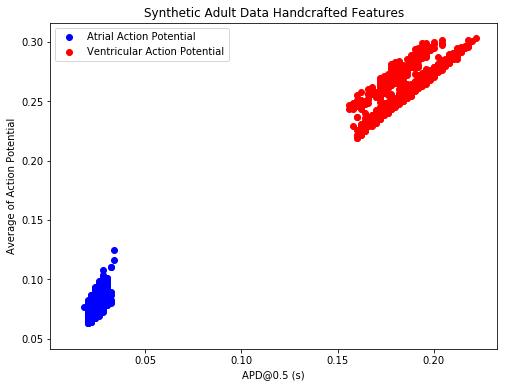

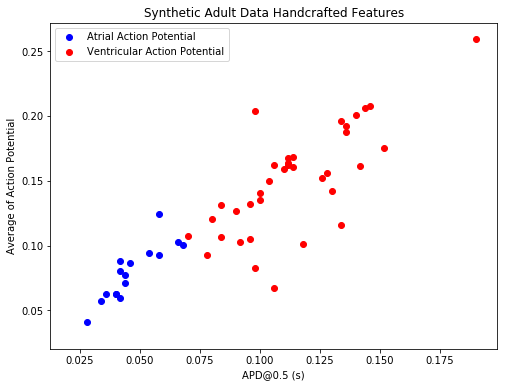

In [11]:
#####Preliminary Examination of Handcrafted Data#####
plt.figure(figsize=(8,6))
plt.title("Synthetic Adult Data Handcrafted Features")
plt.scatter(syn_adult_data_handcrafted[0][0:1000:1], syn_adult_data_handcrafted[1][0:1000:1], c = 'b', label = 'Atrial Action Potential')
plt.scatter(syn_adult_data_handcrafted[0][1000:2000:1], syn_adult_data_handcrafted[1][1000:2000:1], c = 'r', label = 'Ventricular Action Potential')
plt.legend()
plt.xlabel("APD@0.5 (s)")
plt.ylabel("Average of Action Potential")
plt.show()

plt.figure(figsize=(8,6))
plt.title("Synthetic Adult Data Handcrafted Features")
plt.scatter(kamp_data_handcrafted[0][0:16:1], kamp_data_handcrafted[1][0:16:1], c = 'b', label = 'Atrial Action Potential')
plt.scatter(kamp_data_handcrafted[0][16:52:1], kamp_data_handcrafted[1][16:52:1], c = 'r', label = 'Ventricular Action Potential')
plt.legend()
plt.xlabel("APD@0.5 (s)")
plt.ylabel("Average of Action Potential")
plt.show()

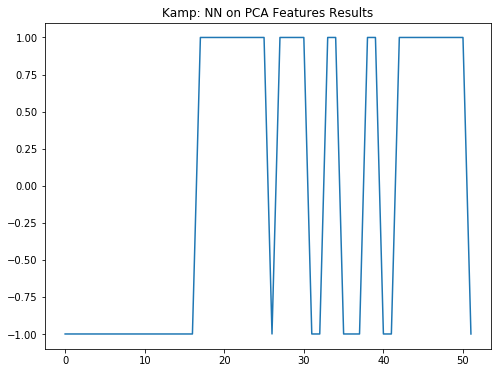

Accuracy: 0.807692307692


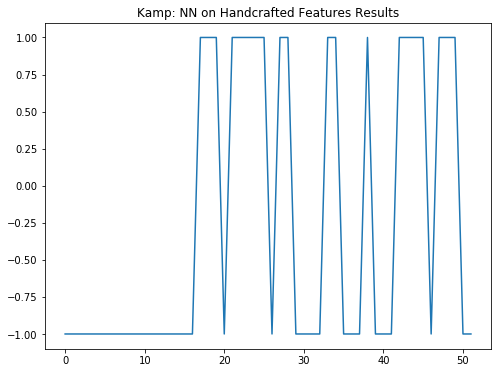

Accuracy: 0.692307692308


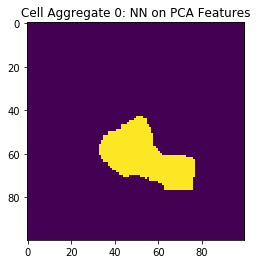

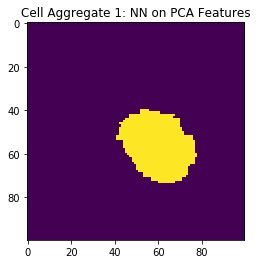

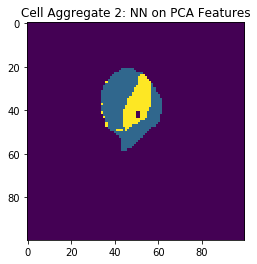

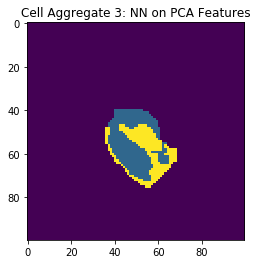

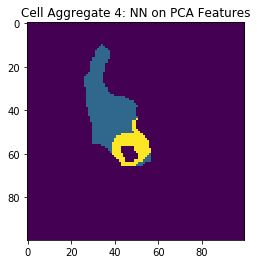

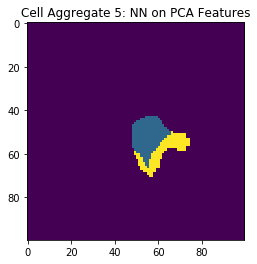

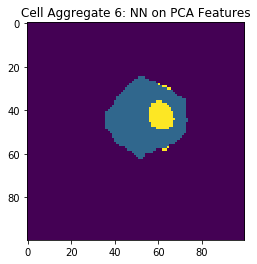

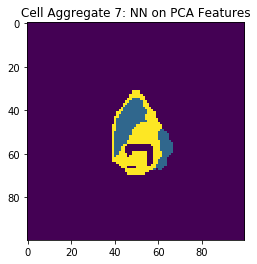

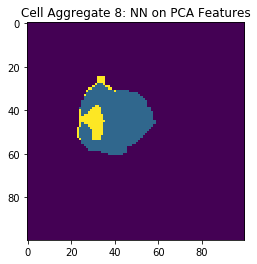

In [ ]:
#####Test 1: Nearest Neighbor Classifier#####

#NN on Kamp PCA Features
kamp_nn_classifier_pca = np.empty(0)
for i in range(len(kamp_data_pca[0])):
    kamp_nn_classifier_pca = np.append(kamp_nn_classifier_pca, nn_classifier(kamp_data_pca[:,[i]], syn_adult_data_pca, syn_adult_labels))
plt.figure(figsize=(8,6))
plt.title("Kamp: NN on PCA Features Results")
plt.plot(kamp_nn_classifier_pca)
plt.show()

print("Accuracy: {}".format(cum_error_calc(kamp_nn_classifier_pca, kamp_labels)))

#NN on Kamp Handcrafted Features
kamp_nn_classifier_handcrafted = np.empty(0)
for i in range(len(kamp_data_handcrafted[0])):
    kamp_nn_classifier_handcrafted = np.append(kamp_nn_classifier_handcrafted, nn_classifier(kamp_data_handcrafted[:,[i]], syn_adult_data_handcrafted, syn_adult_labels))
plt.figure(figsize=(8,6))
plt.title("Kamp: NN on Handcrafted Features Results")
plt.plot(kamp_nn_classifier_handcrafted)
plt.show()
print("Accuracy: {}".format(cum_error_calc(kamp_nn_classifier_handcrafted, kamp_labels)))

#NN on Optical PCA Features
optical_nn_classifier_pca = []
for i in range(9):
    temp = np.zeros(len(optical_data_pca[i][0]))
    for j in range(len(optical_data_pca[i][0])):
        temp[j] = nn_classifier(optical_data_pca[i][:,[j]], syn_adult_data_pca, syn_adult_labels)
    optical_nn_classifier_pca.append(temp)
for i in range(9):
    img = get_aggregate_img(cell_aggregate = i+1, label = optical_nn_classifier_pca[i])
    plt.figure()
    plt.imshow(img)
    plt.title("Cell Aggregate {}: NN on PCA Features".format(i))
    plt.show()

#NN on Optical Handcrafted Features
optical_nn_classifier_handcrafted = []
for i in range(9):
    temp = np.zeros(len(optical_data_handcrafted[i][0]))
    for j in range(len(optical_data_handcrafted[i][0])):
        temp[j] = nn_classifier(optical_data_handcrafted[i][:,[j]], syn_adult_data_handcrafted, syn_adult_labels)
    optical_nn_classifier_handcrafted.append(temp)
for i in range(9):
    img = get_aggregate_img(cell_aggregate = i+1, label = optical_nn_classifier_handcrafted[i])
    plt.figure()
    plt.imshow(img)
    plt.title("Cell Aggregate {}: NN on Handcrafted Features".format(i))
    plt.show()





In [ ]:
#####Test 2: SVM#####
from sklearn.svm import LinearSVC
clf = LinearSVC(dual = False, C=1)
clf.fit(kamp_data_pca.T, kamp_labels)

syn_svm_classifier_pca = clf.predict(syn_adult_data_pca.T)

plt.figure(figsize=(8,6))
plt.plot(syn_svm_classifier_pca)
plt.title("Synthetic: SVC on PCA Features")
plt.show()

print("Accuracy: {}".format(cum_error_calc(syn_svm_classifier_pca, syn_adult_labels)))

optical_svm_classifier_pca = []
for i in range(9):
    optical_svm_classifier_pca.append(clf.predict(optical_data_pca[i].T))
for i in range(9):
    img = get_aggregate_img(cell_aggregate = i+1, label = optical_svm_classifier_pca[i])
    plt.figure()
    plt.imshow(img)
    plt.title("Cell Aggregate {}: SVM on PCA Features".format(i))
    plt.show()

#Handcrafted Features
clf1 = LinearSVC(dual = True, C = 0.5)
clf1.fit(kamp_data_handcrafted.T, kamp_labels)

syn_svm_classifier_handcrafted = clf1.predict(syn_adult_data_handcrafted.T)

plt.figure(figsize=(8,6))
plt.plot(syn_svm_classifier_handcrafted)
plt.title("Synthetic: SVC on Handcrafed Features")
plt.show()

print("Accuracy: {}".format(cum_error_calc(syn_svm_classifier_handcrafted, syn_adult_labels)))

optical_svm_classifier_handcrafted = []
for i in range(9):
    optical_svm_classifier_handcrafted.append(clf1.predict(optical_data_handcrafted[i].T))
for i in range(9):
    img = get_aggregate_img(cell_aggregate = i+1, label = optical_svm_classifier_handcrafted[i])
    plt.figure()
    plt.imshow(img)
    plt.title("Cell Aggregate {}: SVM on Handcrafted Features".format(i))
    plt.show()


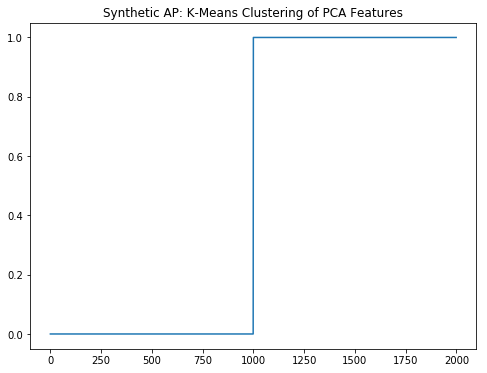

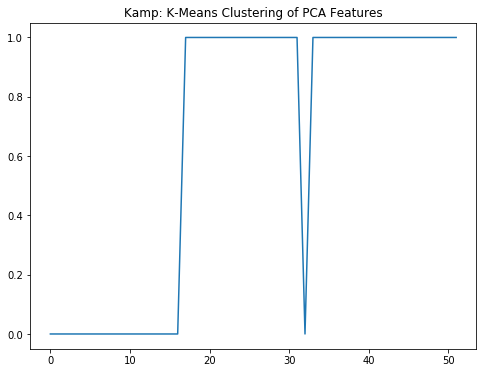

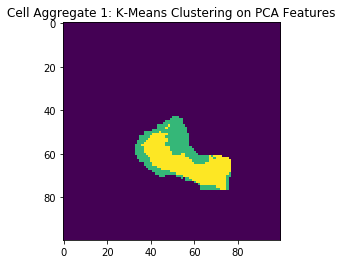

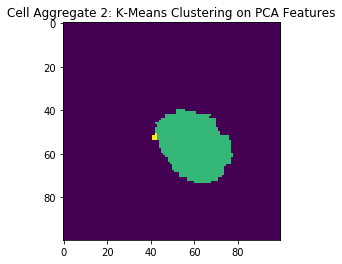

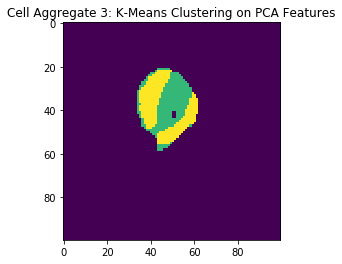

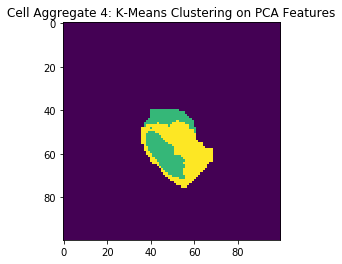

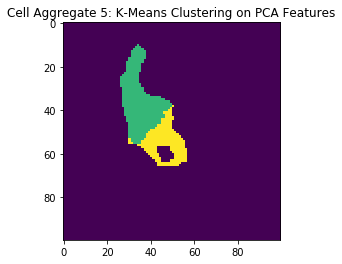

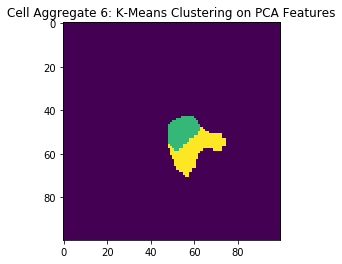

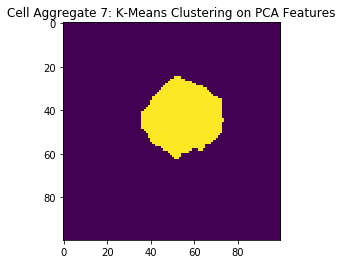

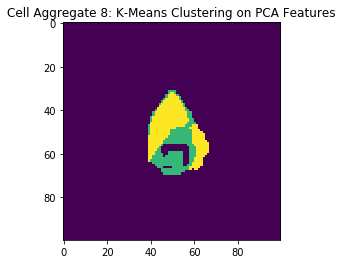

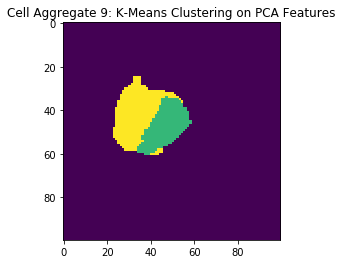

In [63]:
#####Test 3: K-Means#####
syn_kmeans_clustering_pca = kmeans(syn_adult_data_pca, 2, 100)
plt.figure(figsize=(8,6))
plt.plot(syn_kmeans_clustering_pca)
plt.title("Synthetic AP: K-Means Clustering of PCA Features")
plt.show()

kamp_kmeans_clustering_pca = kmeans(kamp_data_pca, 2, 100)
plt.figure(figsize=(8,6))
plt.plot(kamp_kmeans_clustering_pca)
plt.title("Kamp: K-Means Clustering of PCA Features")
plt.show()

#Clustering each aggregate separately
optical_kmeans_clustering_pca = []
for i in range(9):
    optical_kmeans_clustering_pca.append(kmeans(optical_data_pca[i], 2, 100))
for i in range(9):
    img = get_aggregate_img(cell_aggregate = i+1, label = optical_kmeans_clustering_pca[i])
    plt.figure()
    plt.imshow(img)
    plt.title("Cell Aggregate {}: K-Means Clustering on PCA Features".format(i+1))
    plt.show()

In [64]:
optical_data_cumulative_pca = np.empty(0)
for i in range(9):
    if i == 0:
        optical_data_cumulative_pca = optical_data_pca[0]
    else:
        optical_data_cumulative_pca = np.append(optical_data_cumulative_pca, optical_data_pca[i], axis = 1)

#COMBINED DATA
optical_cumulative_kmeans_clustering_mul_agg_pca = kmeans(optical_data_cumulative_pca, 2, 100)
optical_cumulative_kmeans_clustering_pca = []

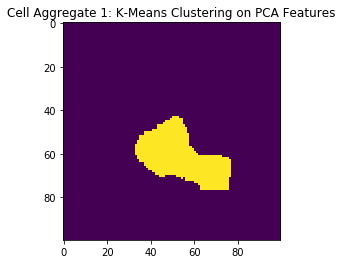

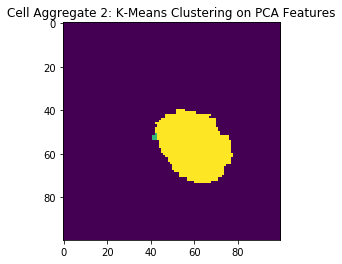

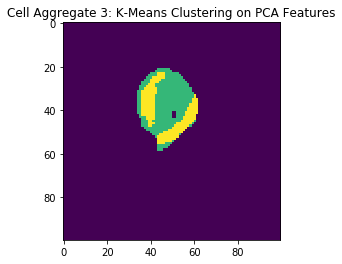

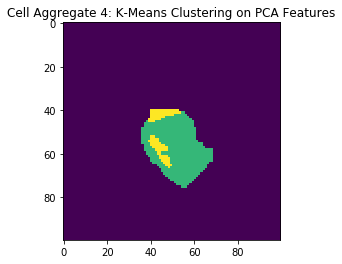

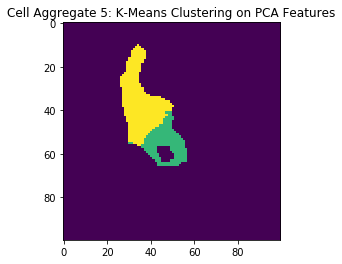

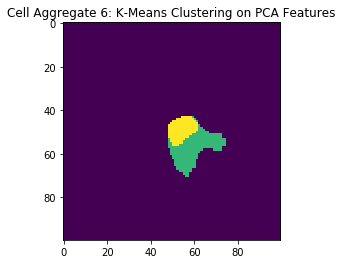

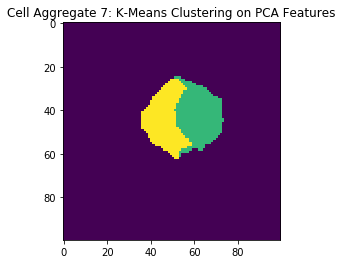

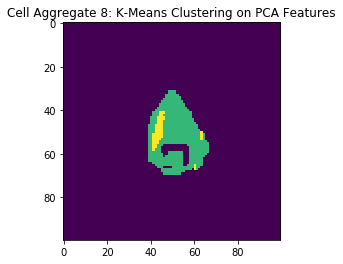

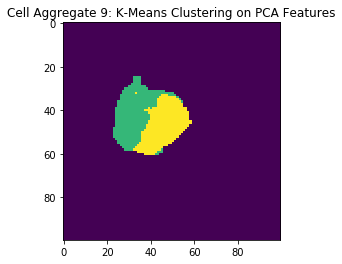

In [65]:
index = 0
optical_cumulative_kmeans_clustering_pca = []
for i in range(9):
    length = len(optical_data_pca[i][0])
    optical_cumulative_kmeans_clustering_pca.append(optical_cumulative_kmeans_clustering_mul_agg_pca[index: index + length:])
    index = index + length

for i in range(9):
    img = get_aggregate_img(cell_aggregate = i+1, label = optical_cumulative_kmeans_clustering_pca[i])
    plt.figure()
    plt.imshow(img)
    plt.title("Cell Aggregate {}: K-Means Clustering on PCA Features".format(i+1))
    plt.show()

In [ ]:
#####DBI Score Summaries#####
optical_nn_classification_pca_x = np.empty(0)
optical_nn_classification_pca_y = np.empty(0)

##NN DBI Tests##

#PCA
#Individual Aggregate DBI
for i in range(9):
    optical_nn_classification_pca_x = np.empty(0)
    optical_nn_classification_pca_y = np.empty(0)
    for j in range(len(optical_nn_classifier_pca[i])):
        if optical_nn_classifier_pca[i][j] == -1:
            if len(optical_nn_classification_pca_x) == 0:
                optical_nn_classification_pca_x = optical_data_pca[i][:,[j]]
            else:
                optical_nn_classification_pca_x = np.append(optical_nn_classification_pca_x, optical_data_pca[i][:,[j]], axis = 1)
        else:
            if len(optical_nn_classification_pca_y) == 0:
                optical_nn_classification_pca_y = optical_data_pca[i][:,[j]]
            else:
                optical_nn_classification_pca_y = np.append(optical_nn_classification_pca_y, optical_data_pca[i][:,[j]], axis = 1)
    
    if len(optical_nn_classification_pca_x) == 0 or len(optical_nn_classification_pca_y) == 0:
        print("DBI Score for Aggregate {} for NN Classification of Optical Data (PCA): --".format(i+1))
    else:
        dbi = dbscore(optical_nn_classification_pca_x, optical_nn_classification_pca_y)
        print("DBI Score for Aggregate {} for NN Classifiction of Optical Data (PCA): {}".format(i+1, dbi))

#Total DBI
optical_nn_classification_pca_x = np.empty(0)
optical_nn_classification_pca_y = np.empty(0)
for i in range(9):
    for j in range(len(optical_nn_classifier_pca[i])):
        if optical_nn_classifier_pca[i][j] == -1:
            if len(optical_nn_classification_pca_x) == 0:
                optical_nn_classification_pca_x = optical_data_pca[i][:,[j]]
            else:
                optical_nn_classification_pca_x = np.append(optical_nn_classification_pca_x, optical_data_pca[i][:,[j]], axis = 1)
        else:
            if len(optical_nn_classification_pca_y) == 0:
                optical_nn_classification_pca_y = optical_data_pca[i][:,[j]]
            else:
                optical_nn_classification_pca_y = np.append(optical_nn_classification_pca_y, optical_data_pca[i][:,[j]], axis = 1)
dbi = dbscore(optical_nn_classification_pca_x, optical_nn_classification_pca_y)
print("DBI Score for All Cells for NN Classification of Optical Data (PCA): {}".format(dbi))

#Handcrafted
#Individual Aggregate DBI
for i in range(9):
    optical_nn_classification_handcrafted_x = np.empty(0)
    optical_nn_classification_handcrafted_y = np.empty(0)
    for j in range(len(optical_nn_classifier_handcrafted[i])):
        if optical_nn_classifier_handcrafted[i][j] == -1:
            if len(optical_nn_classification_handcrafted_x) == 0:
                optical_nn_classification_handcrafted_x = optical_data_handcrafted[i][:,[j]]
            else:
                optical_nn_classification_handcrafted_x = np.append(optical_nn_classification_handcrafted_x, optical_data_handcrafted[i][:,[j]], axis = 1)
        else:
            if len(optical_nn_classification_handcrafted_y) == 0:
                optical_nn_classification_handcrafted_y = optical_data_handcrafted[i][:,[j]]
            else:
                optical_nn_classification_handcrafted_y = np.append(optical_nn_classification_handcrafted_y, optical_data_handcrafted[i][:,[j]], axis = 1)
    
    if len(optical_nn_classification_handcrafted_x) == 0 or len(optical_nn_classification_handcrafted_y) == 0:
        print("DBI Score for Aggregate {} for NN Classification of Optical Data (Handcrafted): --".format(i+1))
    else:
        dbi = dbscore(optical_nn_classification_handcrafted_x, optical_nn_classification_handcrafted_y)
        print("DBI Score for Aggregate {} for NN Classifiction of Optical Data (Handcrafted): {}".format(i+1, dbi))

#Total DBI
optical_nn_classification_handcrafted_x = np.empty(0)
optical_nn_classification_handcrafted_y = np.empty(0)
for i in range(9):
    for j in range(len(optical_nn_classifier_handcrafted[i])):
        if optical_nn_classifier_handcrafted[i][j] == -1:
            if len(optical_nn_classification_handcrafted_x) == 0:
                optical_nn_classification_handcrafted_x = optical_data_handcrafted[i][:,[j]]
            else:
                optical_nn_classification_handcrafted_x = np.append(optical_nn_classification_handcrafted_x, optical_data_handcrafted[i][:,[j]], axis = 1)
        else:
            if len(optical_nn_classification_handcrafted_y) == 0:
                optical_nn_classification_handcrafted_y = optical_data_handcrafted[i][:,[j]]
            else:
                optical_nn_classification_handcrafted_y = np.append(optical_nn_classification_handcrafted_y, optical_data_handcrafted[i][:,[j]], axis = 1)
dbi = dbscore(optical_nn_classification_handcrafted_x, optical_nn_classification_handcrafted_y)
print("DBI Score for All Cells for NN Classification of Optical Data (Handcrafted): {}".format(dbi))

##SVM DBI Test##
#Individual Aggregate DBI
for i in range(9):
    optical_svm_classification_pca_x = np.empty(0)
    optical_svm_classification_pca_y = np.empty(0)
    for j in range(len(optical_svm_classifier_pca[i])):
        if optical_svm_classifier_pca[i][j] == -1:
            if len(optical_svm_classification_pca_x) == 0:
                optical_svm_classification_pca_x = optical_data_pca[i][:,[j]]
            else:
                optical_svm_classification_pca_x = np.append(optical_svm_classification_pca_x, optical_data_pca[i][:,[j]], axis = 1)
        else:
            if len(optical_svm_classification_pca_y) == 0:
                optical_svm_classification_pca_y = optical_data_pca[i][:,[j]]
            else:
                optical_svm_classification_pca_y = np.append(optical_svm_classification_pca_y, optical_data_pca[i][:,[j]], axis = 1)
    
    if len(optical_svm_classification_pca_x) == 0 or len(optical_svm_classification_pca_y) == 0:
        print("DBI Score for Aggregate {} for SVM Classification of Optical Data (PCA): --".format(i+1))
    else:
        dbi = dbscore(optical_svm_classification_pca_x, optical_svm_classification_pca_y)
        print("DBI Score for Aggregate {} for SVM Classifiction of Optical Data (PCA): {}".format(i+1, dbi))

#Total DBI
optical_svm_classification_pca_x = np.empty(0)
optical_svm_classification_pca_y = np.empty(0)
for i in range(9):
    for j in range(len(optical_svm_classifier_pca[i])):
        if optical_svm_classifier_pca[i][j] == -1:
            if len(optical_svm_classification_pca_x) == 0:
                optical_svm_classification_pca_x = optical_data_pca[i][:,[j]]
            else:
                optical_svm_classification_pca_x = np.append(optical_svm_classification_pca_x, optical_data_pca[i][:,[j]], axis = 1)
        else:
            if len(optical_svm_classification_pca_y) == 0:
                optical_svm_classification_pca_y = optical_data_pca[i][:,[j]]
            else:
                optical_svm_classification_pca_y = np.append(optical_svm_classification_pca_y, optical_data_pca[i][:,[j]], axis = 1)
dbi = dbscore(optical_svm_classification_pca_x, optical_svm_classification_pca_y)
print("DBI Score for All Cells for SVM Classification of Optical Data (PCA): {}".format(dbi))

#Individual Aggregate DBI
for i in range(9):
    optical_svm_classification_handcrafted_x = np.empty(0)
    optical_svm_classification_handcrafted_y = np.empty(0)
    for j in range(len(optical_svm_classifier_handcrafted[i])):
        if optical_svm_classifier_handcrafted[i][j] == -1:
            if len(optical_svm_classification_handcrafted_x) == 0:
                optical_svm_classification_handcrafted_x = optical_data_handcrafted[i][:,[j]]
            else:
                optical_svm_classification_handcrafted_x = np.append(optical_svm_classification_handcrafted_x, optical_data_handcrafted[i][:,[j]], axis = 1)
        else:
            if len(optical_svm_classification_handcrafted_y) == 0:
                optical_svm_classification_handcrafted_y = optical_data_handcrafted[i][:,[j]]
            else:
                optical_svm_classification_handcrafted_y = np.append(optical_svm_classification_handcrafted_y, optical_data_handcrafted[i][:,[j]], axis = 1)
    
    if len(optical_svm_classification_handcrafted_x) == 0 or len(optical_svm_classification_handcrafted_y) == 0:
        print("DBI Score for Aggregate {} for SVM Classification of Optical Data (Handcrafted): --".format(i+1))
    else:
        dbi = dbscore(optical_svm_classification_handcrafted_x, optical_svm_classification_handcrafted_y)
        print("DBI Score for Aggregate {} for SVM Classifiction of Optical Data (Handcrafted): {}".format(i+1, dbi))

#Total DBI
optical_svm_classification_handcrafted_x = np.empty(0)
optical_svm_classification_handcrafted_y = np.empty(0)
for i in range(9):
    for j in range(len(optical_svm_classifier_handcrafted[i])):
        if optical_svm_classifier_handcrafted[i][j] == -1:
            if len(optical_svm_classification_handcrafted_x) == 0:
                optical_svm_classification_handcrafted_x = optical_data_handcrafted[i][:,[j]]
            else:
                optical_svm_classification_handcrafted_x = np.append(optical_svm_classification_handcrafted_x, optical_data_handcrafted[i][:,[j]], axis = 1)
        else:
            if len(optical_svm_classification_handcrafted_y) == 0:
                optical_svm_classification_handcrafted_y = optical_data_handcrafted[i][:,[j]]
            else:
                optical_svm_classification_handcrafted_y = np.append(optical_svm_classification_handcrafted_y, optical_data_handcrafted[i][:,[j]], axis = 1)

if len(optical_svm_classification_handcrafted_x) == 0 or len(optical_svm_classification_handcrafted_y) == 0:
        print("DBI Score for All Cells for SVM Classification of Optical Data (Handcrafted): {}".format(dbi))
else:
    dbi = dbscore(optical_svm_classification_handcrafted_x, optical_svm_classification_handcrafted_y)
    print("DBI Score for All Cells for SVM Classification of Optical Data (Handcrafted): {}".format(dbi))                



"""

optical_kmeans_clustering_x = np.empty(0)
optical_kmeans_clustering_y = np.empty(0)
for i in range(9):
    for j in range(len(optical_kmeans_clustering_pca[i])):
        if optical_kmeans_clustering_pca[i][j] == 0:
            if len(x) == 0:
                x = optical_data_pca[i][:,[j]]
            else:
                x = np.append(x, optical_data_pca[i][:,[j]], axis = 1)
        else:
            if len(y) == 0:
                y = optical_data_pca[i][:,[j]]
            else:
                y = np.append(y, optical_data_pca[i][:,[j]], axis = 1)
"""
            

In [28]:
x = np.empty(0)
print(len(x))

0
